In [1]:

import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz
import os
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.contrib.examples.util  # patches torchvision
from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from IPython.display import clear_output


# B.1

## Data

In [2]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = f(X)
x = torch.tensor([-1/4])
XNew = torch.linspace(-1, 1, steps=200)

In [3]:
x2 = torch.tensor([-1/4, 1/4])

## Gaussian process definition

In [4]:
def make_gpr(X,y, default = True, kernel = None, prior_dict = None):
    pyro.clear_param_store()
    if default:
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    else:
        assert kernel is not None
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(kernel, attr, prior)
    return gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**(-4)))

## MCMC hyper-parameters

In [5]:
#C = 4
#W = 500
#N = 500
C = 2
W = 1
N = 4

## Sampling posterior of GP with MCMC

In [6]:
def mcmc_sampler(gpr, C, W, N):
    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile = True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=N,
                        num_chains=C, warmup_steps = W)
    mcmc.run()
    return mcmc

In [7]:
gpr = make_gpr(X, y)
mcmc = mcmc_sampler(gpr, C, W, N)

Warmup [1]:   0%|          | 0/5 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5 [00:00, ?it/s]

c:\Users\Jacki\anaconda3\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
c:\Users\Jacki\anaconda3\lib\site-packages\torch\autograd\__init__.py:300: UserWarning: operator () profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profile information (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## Estimates of mean and variance based on samples

In [8]:
def predictive(x, gpr, default = True, prior_dict = None):
    if default:
        gpr.kernel.variance = pyro.nn.module.PyroSample(dist.LogNormal(-1.0, 1.0))
        gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    else:
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(gpr.kernel, attr, prior)
    loc, cov = gpr(x, noiseless = False, full_cov = True)
    var = cov.diag()
    pyro.sample("loc", dist.Delta(loc))
    pyro.sample("var", dist.Delta(var))
    pyro.sample("f", dist.Normal(loc, var))

In [9]:
def sample_predict(x, gpr, mcmc):
    posterior_samples=mcmc.get_samples(group_by_chain=True)
    posterior_samples_flat = {k : v.flatten() for (k,v) in posterior_samples.items()}
    posterior_predictor = pyro.infer.Predictive(predictive, posterior_samples = posterior_samples_flat)
    posterior_predictive = posterior_predictor(x,gpr)
    return posterior_predictive, posterior_samples

In [10]:
posterior_predictive, posterior_samples = sample_predict(x2, gpr, mcmc)
posterior_locs = posterior_predictive['loc']
posterior_vars = posterior_predictive['var']
posterior_lengthscale = posterior_samples['kernel.lengthscale']
posterior_variance = posterior_samples['kernel.variance']

## A scatter plot on log-log scale of N = 500 samples from $P(\theta | \mathcal{D})$

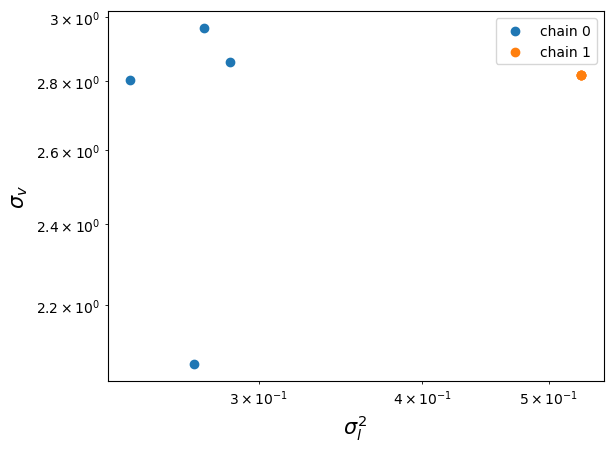

In [11]:
for c in range(C):
    plt.scatter(posterior_lengthscale[c],posterior_variance[c], label = "chain " + str(c))
plt.xlabel(r"$\sigma_l^2$", fontsize = 15)
plt.ylabel(r"$\sigma_v$", fontsize=15)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

## Sample quality analysis

c:\Users\Jacki\anaconda3\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.398  0.141     0.239      0.529      0.052    0.039   
kernel.variance     2.745  0.280     2.065      2.964      0.104    0.077   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale       7.0       7.0   1.83  
kernel.variance          7.0       7.0   3.75  


array([<AxesSubplot:title={'center':'kernel.lengthscale'}>,
       <AxesSubplot:title={'center':'kernel.variance'}>], dtype=object)

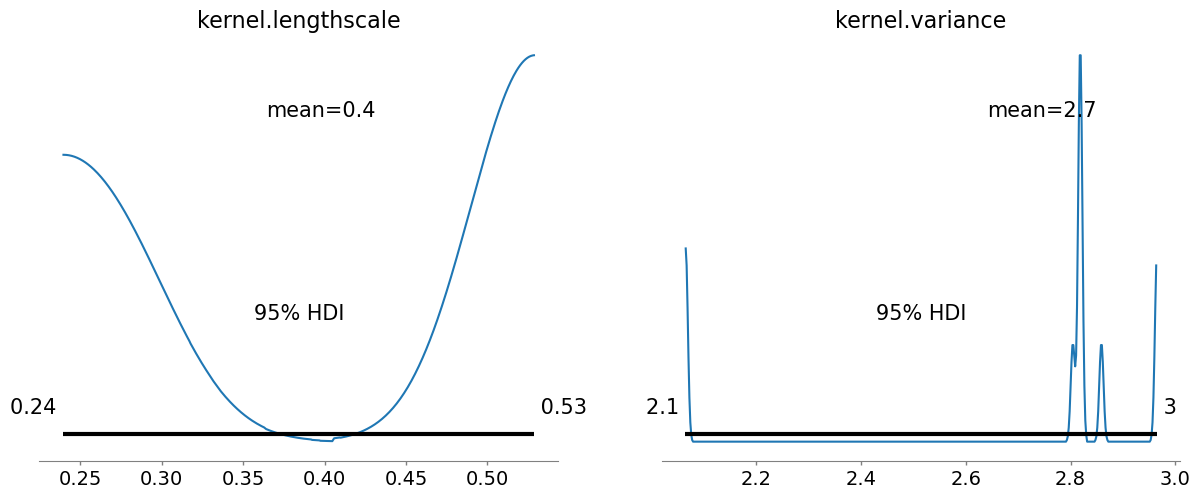

In [12]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data, hdi_prob=0.95)
print(summary)
arviz.plot_posterior(data, hdi_prob=0.95)


## Plot visualizing $p(f^* | x^*, \mathcal{D})$

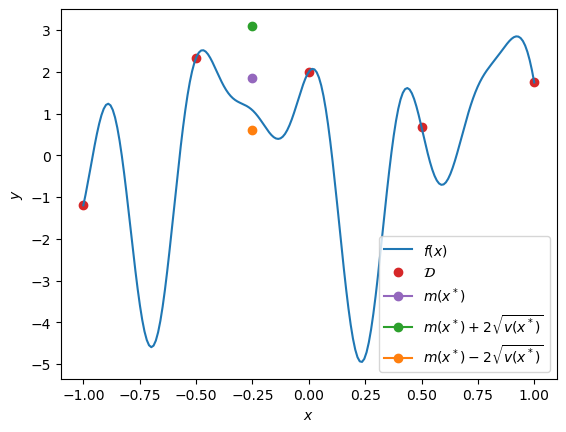

In [13]:
plt.plot(XNew, f(XNew), label = r"$f(x)$")
plt.scatter(X, y, color = 'tab:red', label = r"$\mathcal{D}$")
plt.plot(x, posterior_locs.mean(), color = 'tab:purple', label = r"$m(x^*)$", marker = "o")
plt.plot(x, posterior_locs.mean() + 2*np.sqrt(posterior_vars.mean()), color='tab:green', label=r"$m(x^*) + 2\sqrt{v(x^*)}$", marker="o")
plt.plot(x, posterior_locs.mean() -2*np.sqrt(posterior_vars.mean()), color='tab:orange', label=r"$m(x^*) -2\sqrt{v(x^*)}$", marker="o")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

# B.2

## Algorithm definition

In [14]:
def algorithm1(X, y, XNew, T, C=C, W=W, N = N):
    X_aug = torch.cat((X, torch.empty(T)))
    y_aug = torch.cat((y, torch.empty(T)))
    X_dim = X.shape[0]
    y_dim = y.shape[0]
    mean_list = []
    var_list = []
    fs_list = []
    min_list = []
    for k in range(T):
        clear_output(wait=True)
        print("Iteration " + str(k) + "/" + str(T))
        pyro.clear_param_store()
        X_k = X_aug[:X_dim + k]
        y_k = y_aug[:y_dim + k]
        gpr = make_gpr(X_k, y_k)
        mcmc = mcmc_sampler(gpr, C, W, N)
        posterior_predictive, _ = sample_predict(XNew, gpr, mcmc)
        fs = posterior_predictive['f'].mean(dim=0)
        ps = torch.argmin(fs)
        X_min = XNew[ps]
        y_min = f(X_min)
        X_aug[X_dim+k] = X_min
        y_aug[y_dim+k] = y_min
        fs_list.append(fs)
        mean_list.append(posterior_predictive['loc'].mean(dim=0))
        var_list.append(posterior_predictive['var'].mean(dim=0))
        min_list.append([X_min, y_min])
    return mean_list, var_list, fs_list, min_list


## Algorithm hyper-parameters

In [15]:
T = 100
C = 1
N = 1
W = 100

## Running the algorithm

In [16]:
mean_list,var_list, fs_list, min_list = algorithm1(X, y, XNew, T, C, W, N)

Iteration 40/100


Warmup:   0%|          | 0/101 [00:00, ?it/s]c:\Users\Jacki\anaconda3\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:  72%|███████▏  | 73/101 [01:55,  2.00s/it, step size=3.96e-05, acc. prob=0.750]

In [ ]:
plt.plot(np.array(min_list)[:,1])